In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from fastai import *
from fastai.text import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

print(torch.cuda.get_device_name(device=None))

Tesla K80


# `ULMFiT` Sentiment Analysis of Yelp Reviews
* The ULMFiT NLP transfer learning technique, was introduced in this 2018 paper (https://arxiv.org/pdf/1801.06146.pdf)
* Explaination of usage comes from this excellent course by Rachel Thomas (https://www.fast.ai/2019/07/08/fastai-nlp/)


### The model works in three stages
1. The `AWD-LSTM SequentialRNN` is pretrained on a general-domain corpus, in our case the `WikiText103` dataset.
2. The `AWD-LSTM Language model`, training as a sequence generator, is then fine-tuned on the domain-specific corpus (Yelp reviews).
3. The embeddings learnt from these first two steps are imported into a new `classifier model`, which is fine-tuned on the target task (star ratings) with gradual unfreezing of the final layers.

In [2]:
path = untar_data(URLs.YELP_REVIEWS)
df_train = pd.read_csv(path/'train.csv', header=None, names=['rating', 'text']) \
             .sample(frac=0.05, random_state=1)
df_test = pd.read_csv(path/'test.csv', header=None, names=['rating', 'text']) \
            .sample(frac=0.05, random_state=1)

* Taking sample set for development

In [3]:
print(df_train.shape, df_test.shape)
df_train.head()

(32500, 2) (2500, 2)


,rating,text
21194,1,Thank you for all the emails you sent me on my...
373117,4,"I, myself, and vietnamese and have tried all d..."
470627,3,"3.5 stars.\n\nI have had BFG on my list of \""m..."
256672,3,Edamame with truffle salt was great; really li...
465495,4,So I'm running errands before I go back to th...


In [4]:
# First review
df_train['text'][21194][:500]

'Thank you for all the emails you sent me on my review! I was surprised at how many responses I recieved from people searching for the right dentist..\\nI shared my new dentist information and even got some movie tickets from my dentist for the referrals!\\nI find it funny how since I wrote this review how many people have reviewed with 5 stars... They must have a lot of friends and family! \\nI hope everyone reads my review and picks the right dentist for your needs!\\nHappy Holidays'

### Split into `training`, `validation` and `hold-out` test set (df_test)

In [5]:
from sklearn.model_selection import train_test_split

# Split data into training and validation set
df_trn, df_val = train_test_split(df_train, stratify=df_train['rating'],
                                  test_size=0.2, random_state=1)
print(df_trn.shape, df_val.shape)

(26000, 2) (6500, 2)


In [6]:
%%time
df_trn.to_csv(path / 'train_sample.csv')
df_val.to_csv(path / 'val_sample.csv')
df_test.to_csv(path / 'test_sample.csv')

CPU times: user 592 ms, sys: 72 ms, total: 664 ms
Wall time: 666 ms


In [7]:
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/yelp_review_full_csv/readme.txt'),
 PosixPath('/home/ubuntu/.fastai/data/yelp_review_full_csv/val_sample.csv'),
 PosixPath('/home/ubuntu/.fastai/data/yelp_review_full_csv/test.csv'),
 PosixPath('/home/ubuntu/.fastai/data/yelp_review_full_csv/test_sample.csv'),
 PosixPath('/home/ubuntu/.fastai/data/yelp_review_full_csv/train_sample.csv'),
 PosixPath('/home/ubuntu/.fastai/data/yelp_review_full_csv/train.csv'),
 PosixPath('/home/ubuntu/.fastai/data/yelp_review_full_csv/models')]

### Tokenization
* The first step of processing we make the texts go through is to split the raw sentences into words, or `tokens`.

In [8]:
%%time
data = TextClasDataBunch.from_csv(path, 'train_sample.csv', 
                                  text_cols='text', label_cols='rating')
data.show_batch()

text,target
"xxbos xxmaj with a name like xxmaj ping xxmaj pang xxmaj pong , you 're not sure if you 're headed to one of ' those ' shows in xxmaj thailand or sitting down for some dim sum at a xxmaj chinese restaurant . xxmaj when in xxmaj vegas , it 's the latter ... at least in this case . \n \n xxmaj seeing billboards all over town",3
"xxbos a place that has been on our ' wish list ' for , like , forever .. has been xxmaj bratalian ... xxmaj ever since xxmaj chef 's xxmaj palate closed down , we 've been missing a really good gourmet restaurant on our side of town ... \n \n xxmaj so when xxmaj rick 's xxmaj dad suggested that we go , ( he read about xxmaj",3
"xxbos i have really mixed feelings about the xxup core xxmaj institute . xxmaj my two main problems with xxup core are \n \n 1 ) it 's drive - thru pain management and \n 2 ) xxup xxunk patients seem to be treated with lesser care . \n \n xxmaj having said that , i do n't have any experience with other pain xxunk clinics to",3
"xxbos xxmaj food & xxmaj drinks : 4 stars \n xxmaj service : negative 5 stars \n \n xxmaj we 've been to xxmaj havana xxmaj cafe twice , however , the service that we received on our most recent visit is enough to make us rethink attempting to dine there again . xxmaj on our first visit , we sat at the bar and had some mojitos",3
"xxbos xxmaj my hubby and i decided to celebrate our wedding anniversary at xxmaj andre 's after reading a great amount of rave reviews about this restaurant . xxmaj what also had us interested was the fact that this restaurant received the xxup aaa 4 xxmaj diamond award , had been recognized by the xxmaj michelin xxmaj guide with one star rating , and is xxunk as xxmaj las xxmaj",2


CPU times: user 9.58 s, sys: 1.62 s, total: 11.2 s
Wall time: 29.2 s


### Numericalization into `vocab`

* Creating unique tokens for words
* Top 60,000 used by default - unknown token `xxunk` used for remainders
* Special characters are also tokenised (spaces, punctuation, new lines)
* `xxbos` is the token for beginning of sentence etc..

In [9]:
# Top 10 words
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

In [10]:
# Example tokenised review
data.train_ds[0][0].text[:200]

"xxbos xxmaj service was horrible . xxmaj took forever to get a server . xxmaj wings were undercooked . xxmaj wo n't come back"

In [11]:
# Example numerical token mapping onto index
data.train_ds[0][0].data[:10]

array([   2,    5,   70,   16,  488,    9,    5,  186, 1010,   15])

## For sentiment analysis we are creating two models
1. A language model `data_lm` (fine-tuned encoder, no labels)
2. A text classification model `data_clas` (with labels)

### 1. Language Model
* Model `AWD_LSTM` is pretrained on a processed subset of wikipedia `wikitext-103`
* This RNN model is trained to predict what the next word in the sequence is
* It has a recurrent structure and a hidden state (updated each time it sees a new word), which contains information about the sentence


In [12]:
# Decrease batchsize if GPU can't handle the load
bs = 24       # range 12 - 48

In [13]:
%%time
# Language Model data
data_lm = TextLMDataBunch.from_df(path, df_trn, df_val)

print('Training and validation shape:\n', df_trn.shape, df_val.shape)
data_lm.show_batch(rows=1)

Training and validation shape:
 (26000, 2) (6500, 2)


idx,text
0,"caught his attention , that he was being tipped to get in and that they have to tip him to get in ! i literally was lost for words . xxmaj this club is not organized or worth going into ! i 'm not going to sit there and tip this dude to get in .. and especially to a snob like him . xxbos xxmaj two expensive sides thrown"


CPU times: user 4.18 s, sys: 1.03 s, total: 5.2 s
Wall time: 24.7 s


In [14]:
# Transfer learning Model AWD_LSTM pre-trained on WikiText103

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 42.3 s, sys: 20.4 s, total: 1min 2s
Wall time: 1min 5s


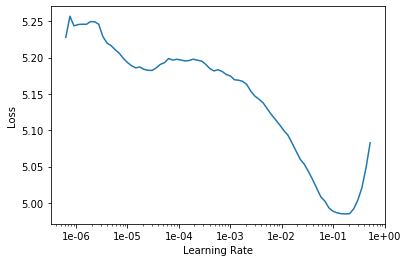

In [15]:
%%time
# Find best learning rate from slope
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [16]:
# Only the last layer is unfrozen during training
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
Linear               [70, 47568]          19,074,768 True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 19,074,768
Total trainable params: 19,074,768
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss fu

In [15]:
# Training/fine-tuning final layer to yelp reviews

learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.003754,3.870956,0.282358,08:34


* `Accuracy` here is the ability for the model to predict the next word in the sequence

In [16]:
%%time
# Run until valid_loss comes down to training_loss (past this is overfitting to training set)

learn.fit_one_cycle(3, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.826181,3.847477,0.284040,08:35
1,3.798512,3.827782,0.285751,08:40
2,3.764477,3.824101,0.286011,08:34


CPU times: user 17min 24s, sys: 8min 31s, total: 25min 56s
Wall time: 25min 50s


In [17]:
learn.save_encoder('fine_tuned_enc')

* Now, the encoder is fine tuned to `Yelp Reviews`
* The encoder can be used to predict the next word in a sentence
* The next step is to remove the final layers of the encoder, and replace them with a classification/regression model

In [18]:
data_lm.train_ds.inner_df.shape

(26000, 2)

In [19]:
data_lm.valid_ds.inner_df.shape

(6500, 2)

In [26]:
learn.predict("I really loved the restaurant, the food was")

'I really loved the restaurant, the food was ok'

### Predicting `next word` with language model

In [42]:
learn.predict("I really loved the restaurant, the food was")

'I really loved the restaurant, the food was fantastic'

In [29]:
learn.predict("I hated the restaurant, the food tasted")

'I hated the restaurant, the food tasted pretentious'

### Generating fake yelp reviews with `RNN` output sequence

In [37]:
text = "The food is good and the staff"
words = 40

print(learn.predict(text, words, temperature=0.75))

The food is good and the staff is friendly . They make it a great alternative to the Asian food fare , and the food is delicious . It 's always a good place to eat . 
 
  Its fun , very tasty


# 2. Classification Model for `Sentiment Analysis`

In [38]:
%%time
# 2. Classification Model
data_clas = TextClasDataBunch.from_df(path, df_trn, df_val, vocab=data_lm.train_ds.vocab)
data_clas.show_batch(rows=1)

text,target
xxbos xxmaj fugg this place ! i xxmaj was here 12 / 24 / 14 . xxmaj our room was n't ready yet so we went in to kill time . \n \n i got a latte and slice of banana nut brand . xxmaj the total came to $ 9.19 . i used my debit card . i added on a $ 2.00 tip to the bill .,1


CPU times: user 6.98 s, sys: 1.22 s, total: 8.2 s
Wall time: 26.5 s


* Instantiate new learner, and load embeddings from fine-tuning

In [39]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
learn_c.load_encoder('fine_tuned_enc')
learn_c.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


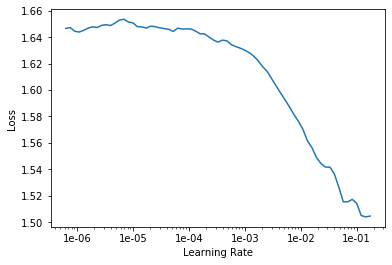

In [52]:
learn_c.lr_find()
learn_c.recorder.plot(skip_end=15)

In [40]:
learn_c.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.142674,1.035260,0.543692,03:37


In [41]:
learn_c.save('first')

In [42]:
learn_c.load('first');

* Gradual unfreezing is used to preserve low-level representations and adapt high-level ones

In [43]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.037245,0.927359,0.593538,04:26


In [44]:
learn_c.save('2nd')

In [45]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.923852,0.862713,0.620308,05:36


The accuracy suggests the model guesses the correct star value 62% of the time

# Review Predictions

In [170]:
# Example review
learn_c.predict("I really loved the restaurant, it was awesome!")

(Category 5,
 tensor(4),
 tensor([6.1841e-05, 1.9086e-04, 7.6181e-03, 2.1801e-01, 7.7412e-01]))

In [47]:
learn_c.predict("I really hated the restaurant, it was disgusting!")

(Category 1,
 tensor(0),
 tensor([9.1713e-01, 8.0456e-02, 2.3241e-03, 6.7944e-05, 1.9538e-05]))

In [171]:
learn_c.predict("I went there with my friends, it was okay.")

(Category 3, tensor(2), tensor([0.0071, 0.2063, 0.7228, 0.0605, 0.0033]))

In [51]:
# Random sample from the hold-out test set

for index, row in df_test.sample(5).iterrows():
    print("\nPrediction:", learn_c.predict(row[1])[0])
    print("    Actual:", row[0])
    print(f"({index})", row[1])


Prediction: 3
    Actual: 3
(28591) Definitely overpriced for what it is.\n\nI had been to the Dilworth location before and really enjoyed it. This time i had a Creative Loafing deal and decided to try the Stonecrest location. I was definitely underwhelmed. We had a reservation for 7:00. When we arrived we were promptly seated. I immediately felt like i was at Chuck E Cheese or Red Robin. Kids Galore!! So much for date night. Our tables were so close together it was a little uncomfortable. \n\nWe ordered the Fajitas for two with Steak and Beef. The little tapas they brought out were pretty tasty. The fajitas were a little overpriced in my opinion. We maybe had 10 pieces of chicken on a platter of zucchini, onions and mushrooms. $30 for some veggies is a little crazy. \n\nI would maybe go back but not likely.

Prediction: 3
    Actual: 4
(16844) I have waited to give this place a second visit before writing a review, because the first visit (Jan 09) was so stellar that it was almost to

In [52]:
# Get predictions on validation set
preds, targets = learn_c.get_preds()
predictions = np.argmax(preds, axis = 1)

### Validation set: `Actual` vs. `Prediction`

In [76]:
ct = pd.crosstab(predictions, targets)
ct.columns.name = 'Actual'
ct.index.name = 'Predicted'
ct.style.background_gradient()

Actual,0,1,2,3,4
Predicted,,,,,
0,959,245,44,13,7
1,289,760,264,29,11
2,29,235,686,272,34
3,6,29,254,619,250
4,17,19,51,370,1008


* Blue horizontal line counts the correct guesses
* Samples that fall outside the diagonal are incorrect, but usually close to the right star number

## Prediction errors in `hold-out` test set
* The model works well but it's interesting to see it's failure cases

In [140]:
%%time
h_df = df_test.copy().reset_index()
preds = [int(learn_c.predict(text)[0])+1 for text in df_test.text.head(500)]
h_df['predicition'] = pd.Series(preds)
h_df.head()

CPU times: user 1min 5s, sys: 13.6 s, total: 1min 19s
Wall time: 1min 19s


,index,rating,text,predicition
0,26247,3,3.5/5 for me\n\nMake sure to make reservations...,4.0
1,35067,4,"Coffee, Vinyl, and Bechamel....oh, how much th...",4.0
2,34590,4,"As the name suggests, this little-known Greek ...",5.0
3,16668,4,This is a great place for a cuppa joe and work...,4.0
4,12196,4,"We avoided the Saturday Badger crowds, but eve...",3.0


### Reviews rated `1` but model predicts `5`

In [166]:
f1 = h_df[(h_df.rating == 1) & (h_df.predicition == 5)].head(3)
f1

,index,rating,text,predicition
140,49153,1,I mapped out this JJ location to my house and ...,5.0
151,7348,1,I came here one day looking for a new nail sal...,5.0


In [168]:
f1.iloc[0,2]

"I mapped out this JJ location to my house and it is 2.8 miles (6 minute drive), but I called and apparently I'm out of their delivery zone. HUH? 2.8 miles and you don't deliver to me?  No wonder you can be freaky fast, you only deliver to places that are 2 blocks away.  Good business model, don't deliver to people in your same area."

### Reviews rated `5` but model predicts `1`

In [156]:
f2 = h_df[(h_df.rating == 5) & (h_df.predicition == 1)].head(3)
f2

,index,rating,text,predicition
36,10298,5,"Shady, dirty, dark, and stinky. On the plus si...",1.0


In [163]:
f2.iloc[0,2]

'Shady, dirty, dark, and stinky. On the plus side, they do have cheap tables. But despite all that, you come here for  that $1 monster of a hot dog. Five stars for inspiring margarita-drunk ladies to pose promiscuously with this delicacy.'